In [14]:
using Plots
using LaTeXStrings
using LinearAlgebra
using FFTW
using BenchmarkTools


In [15]:
function fftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(fft(B))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return ifft(ifftshift(B))
end

ifftnshift (generic function with 1 method)

In [16]:
function Pixelate_Reciprocal(image, camera_scale, physical_scale)
    # This function pixelates the image in the reciprocal space
    # It is assumed that the image is already in the reciprocal space and normally ordered
    # the averaging kernel is Fourier transform where the scaling ratio its size

    Ny, Nx = size(image)
    N = Nx
    scaling_ratio = round(Int, camera_scale/physical_scale)

    Nx_camera = Nx ÷ scaling_ratio
    Ny_camera = Ny ÷ scaling_ratio
    N_camera = Nx_camera
    

    upper = (N-1)/2 
    lower = (-N+1)/2
    kx = @. (lower:1.0:upper) * 1/(physical_scale*N )
    ky = @. (lower:1.0:upper) * 1/(physical_scale*N )

    prod = @. sinc(kx * scaling_ratio)
    FT_kernel = prod * prod'
    image_lowpass = @. FT_kernel .* image
    
    
    slct_low = (N-N_camera)÷2 + 1
    slct_high = slct_low + N_camera - 1
    kx_pixelated = kx[slct_low:slct_high]
    ky_pixelated = ky[slct_low:slct_high]
    
    image_pixelated = image_lowpass[slct_low:slct_high, slct_low:slct_high]
    image_pixelated = @. image_pixelated/ scaling_ratio^2
    return image_pixelated, kx_pixelated, ky_pixelated
end

Pixelate_Reciprocal (generic function with 1 method)

In [17]:
function Diff_Image(image, c)
    return @. log1p(c*abs(image))
end

Diff_Image (generic function with 1 method)

In [18]:
function Wavelength(E)
    hc = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀ = 511 #keV
    return hc/sqrt(E*(2*E₀ + E))
end

function Focus(E, Cs, nᵢ=1)
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((Cs*Wavelength(E)^3)))^(1/4)

function TEM_Image(wf_transmission, E, Cs)
    Ny, Nx = size(wf_transmission)
    if Nx != Ny
        error("Image must be square")
    elseif 2^(floor(Int, log2(Nx))) != Nx
        error("Image must be power of 2")
    end
    N = Nx

    upper = (N-1)/2 + 0.1
    lower = (-N+1)/2
    kx = lower:1.0:upper
    ky = lower:1.0:upper

    k = @. sqrt(kx'^2 + ky^2)
    disk = k.<=N/2

    λ = Wavelength(E)
    Δf = Focus(E, Cs)
    Hₒ = @. exp(-1im*(π*λ*k^2*(0.5*Cs*λ^2*k^2 - Δf)))*disk
    
    fft_ideal_image = fftnshift(wf_transmission)
    fft_physical_image = fft_ideal_image.*Hₒ
    image_physical = ifftnshift(fft_physical_image)
    
    return image_physical
end

TEM_Image (generic function with 1 method)

In [19]:
E = 300
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms

N = 2^8
physical_scale = 1
camera_scale = 2

upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = lower:1:upper
ky = lower:1:upper

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)

L = 1/(kx[2]-kx[1])
ΔL = L/N

x = LinRange(-L/2, L/2, N)
y = LinRange(-L/2, L/2, N)

λ(E) = Wavelength(E)
Δf(E, Cs) = Focus(E, Cs)

H = @. exp(-1im*(π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs)))*disk)*disk
f(x, y, xc, yc, σ₁, σ₂) = @. (1/((2*pi)*sqrt(σ₁*σ₂)))*exp(-(x - xc)^2/(2σ₁^2) -(y - yc)^2/(2σ₂^2) )
heatmap(kx, ky, angle.(H), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end]);

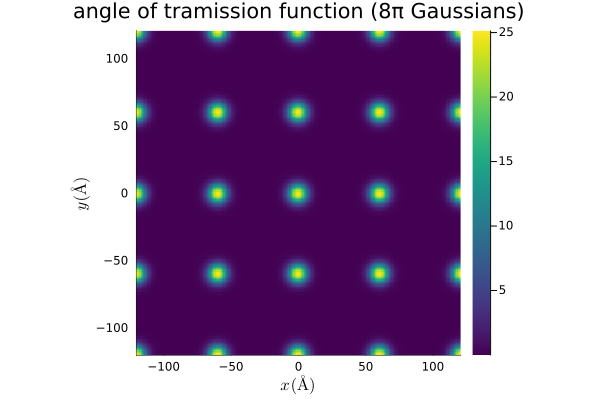

In [20]:
S = 5
σ₊, σ₋ = 5, 5
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
indices = round.(Int, LinRange(1, N, S))
# for i in indices, j in indices
#     phase[j, i] += 1
# end
for i in indices, j in indices
    xc = x[i]
    yc = y[j]
    phase_real += f(x',y, xc, yc, σ₊, σ₋)
    phase_complex += f(x',y, xc, yc, σ₊, σ₋) 
end


phase_real = phase_real./maximum(phase_real) *8*π
phase_complex = phase_complex./maximum(phase_complex) * 0.1
phase = phase_real + 1im*phase_complex

Ψₜ = @. exp(1im*phase)
heatmap(x,y,abs.(phase_real), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)
title!("angle of tramission function (8π Gaussians)")

In [21]:
# Define the incident angle (θ) in radians and wave vector magnitude (k0)
θ = deg2rad(90)      # incident angle (radians)
ϕ = deg2rad(45) # azimuthal angle (radians)

# Wavevector components; here we tilt the plane wave along x-direction
kmag = 2 * pi / Wavelength(300)


# Create the plane wave by computing the phase exp(i*(kx*x + ky*y))
ref_wave = @. exp(1im * kmag * (sin(θ)*cos(ϕ)*x' + sin(θ)*sin(ϕ)*y))

# Plot the amplitude
# heatmap(abs.(ref_wave), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
heatmap(x,y,angle.(ref_wave), aspect_ratio=1, c=:viridis, colorbar=true, axis=true);

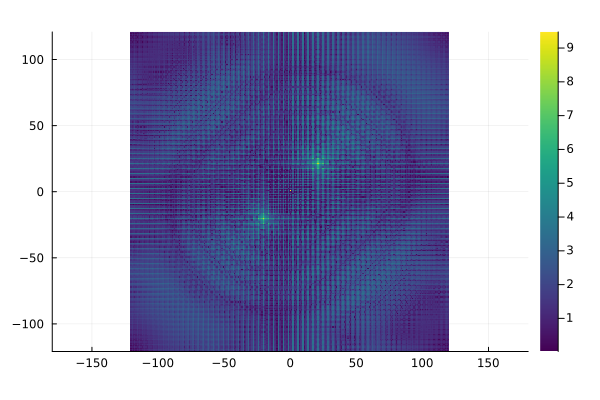

In [22]:
Ψₜ = @. exp(1im*phase)

ideal_measured = abs2.(Ψₜ .+ ref_wave )
ideal_fft = fftnshift(ideal_measured)
heatmap(x,y,Diff_Image(ideal_fft,0.1), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

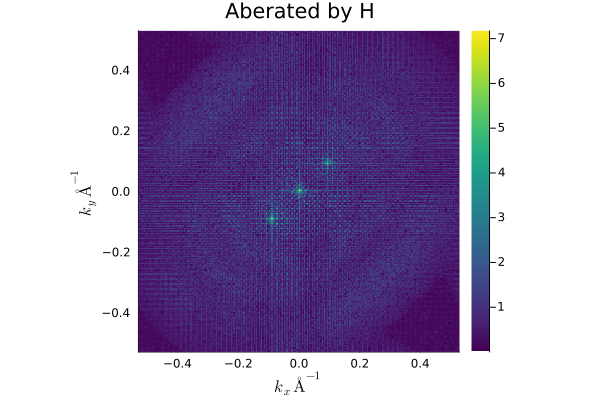

In [23]:
physical = TEM_Image(Ψₜ, E, Cs)
physical_ref = TEM_Image(ref_wave, E, Cs)
physical_measured = @. abs2( physical + physical_ref)
physical_fft = fftnshift(physical_measured)

heatmap(kx,ky,Diff_Image(physical_fft,0.01), 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=:true, 
    axis=true,
    xlabel=L"k_x\, Å^{-1}",
    ylabel=L"k_y\, Å^{-1}",
    title="Aberated by H")
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])

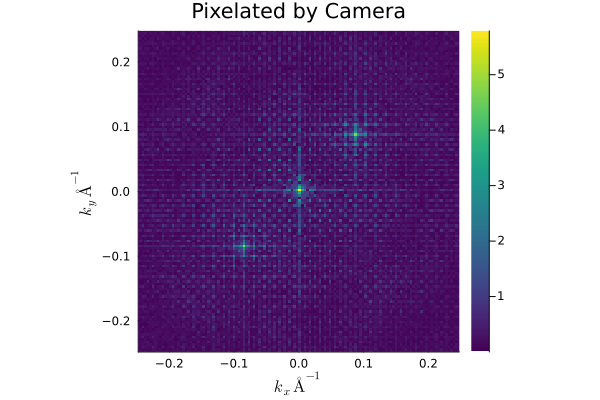

In [26]:
physical_fft_pixelated_in_kspace,kx_camera,ky_camera= Pixelate_Reciprocal(physical_fft, camera_scale, physical_scale)


heatmap(kx_camera,ky_camera,Diff_Image(physical_fft_pixelated_in_kspace,0.01), 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=:true, 
    axis=true,
    xlabel=L"k_x\, Å^{-1}",
    ylabel=L"k_y\, Å^{-1}",
    title="Pixelated by Camera")
xlims!(kx_camera[1], kx_camera[end])
ylims!(ky_camera[1], ky_camera[end])